In [1]:
# initialize libraries
import glob
import pandas as pd
from math import *

# environment/conversion variables
rho = 0.00237
wattsToFtLbPerSec = 0.74

# define motor
efficiency = 0.9 # would like to curve this too based on some real motor data

# define battery
ampLimit = 10
voltage = 10.5 # ultimately should be curve, not flat
craftWeight = 1.1 # lb

availablePower = efficiency*ampLimit*voltage

#
# Hoping to plot using bokeh

In [2]:
def checkForPowerNeeded(rpm, data):
    rps = rpm/60
    j = flightSpeed/(rps*(diameter))
    data = interpolate(j, data)
    cp = float(data[data.J == j]['CP'].tail(1)) # we need to tail() here because sometimes we get two rows.
    # TODO should probably fix that line above eventually
    powerNeeded = cp * rho * rps**3 * diameter**5 / wattsToFtLbPerSec
    return powerNeeded

def checkForPowerNeeded(rpm, data):
    rps = rpm/60
    j = flightSpeed/(rps*(diameter))
    data = interpolate(j, data)
    cp = float(data[data.J == j]['CP'].tail(1)) # we need to tail() here because sometimes we get two rows.
    # TODO should probably fix that line above eventually
    powerNeeded = cp * rho * rps**3 * diameter**5 / wattsToFtLbPerSec
    return powerNeeded

def checkThrust(rpm, data):
    rps = rpm/60
    j = flightSpeed/(rps*(diameter))
    data = interpolate(j, data)
    try:
        ct = float(data[data.J == j]['CT'].tail(1)) # we need to tail() here because sometimes we get two rows.
        # TODO should probably fix that line above eventually
    except TypeError:
        debug(j)
        debug(data)
        debug(data[data.J == j]['CT'].tail(1))
    thrust = ct * rho * rps**2 * diameter**4
    return thrust

def checkPowerOut(rpm, data, velocity):
    thrust = checkThrust(rpm, data)
    return thrust*velocity

def checkEta(rpm, data):
    rps = rpm/60
    j = flightSpeed/(rps*(diameter))
    data = interpolate(j, data)
    eta = float(data[data.J == j]['eta'].tail(1)) # we need to tail() here because sometimes we get two rows.
    # TODO should probably fix that line above eventually
    return eta

def interpolate(j, data):
    newRow = pd.Series([j],index=['J'])
    data = data.append(newRow,ignore_index=True)
    data.set_index('J', inplace=True)
    data.sort_index(inplace=True)
    data.interpolate(inplace=True)
    data.reset_index(inplace=True)
    return data

def debug(string):
    # print(string)
    a = 1
def info(string):
    # print(string)
    a = 1

In [3]:
# define flight regimes
regimes = {}

# takeoff
regimes['takeoff'] = {'min thrust': 0.7, 'flight speed': 20, 'gees': 1}


# climb
v = 35 # fps
PoverW = 45 # w/lb
p = PoverW * craftWeight
thrust = p/v*wattsToFtLbPerSec
regimes['climb'] = {'min thrust': thrust, 'flight speed': v, 'gees': 1}

# cruise
v = 65 # fps
PoverW = 45 # w/lb
p = PoverW * craftWeight
thrust = p/v*wattsToFtLbPerSec
regimes['cruise'] = {'min thrust': thrust, 'flight speed': v, 'gees': 1}
def later():

    # drop
    v = 35 # fps
    PoverW = 20 # w/lb
    p = PoverW * craftWeight
    thrust = p/v*wattsToFtLbPerSec
    regimes['drop'] = {'min thrust': thrust, 'flight speed': v, 'gees': 1}


    # turn
    v = 50 # fps
    PoverW = 45 # w/lb # TODO recalculate based on 4G turn
    p = PoverW * craftWeight
    thrust = p/v*wattsToFtLbPerSec
    regimes['turn'] = {'min thrust': thrust, 'flight speed': v, 'gees': 1}


In [4]:
propellorsTooSmall = 0
propellorsTooBig = 0
staticThrustEntries = 0
prematureBreakouts = 0
geometries = 0

minDiameter = 4 # in
maxDiameter = 12 # in

# final data storage
masterDict = {}

# TODO need to add a provision to skip point if j value is not on the data
for regimeName, regime in regimes.items():
    print(regimeName)

    newLineItems = []
    propTag = ""
    newLineItem = ""
    
    for filename in glob.glob("./UIUC-propDB/good-data/*ance_8.5x7*.txt"):
        if "geom" in filename:
            geometries += 1
            continue
        if "static" in filename:
            staticThrustEntries += 1
            continue
            
        # get propellor specs
        data = pd.read_table(filename, sep="\s+")
        dimensions = (filename.split("_"))
        diameter = float(dimensions[1].split("x")[0])/12 # in feet
        pitch = float(dimensions[1].split("x")[1])
        propName = dimensions[0].split("\\")[1]
        dataRPM = dimensions[-1].split(".")[0]
        debug(propName + " " + dimensions[1].split("x")[0] + " x " + str(pitch) + " @ " + dataRPM + " RPM")
        
        if diameter*12 > maxDiameter or diameter*12 < minDiameter:
            continue
            
        newPropTag = propName + " " + dimensions[1].split("x")[0] + " x " + str(pitch)
        if (newPropTag != propTag):
            # we're at a new propellor
            propTag = newPropTag
            print (propTag)
            rpmDiff = 50000
            # if this isn't the very beginning, add previous propellor's top line item to list
            if newLineItem != "":
                newLineItems.append(newLineItem)


        # we need the maximum and minimum j values to bound our possible ranges
        buffer = data.tail(1)['J']
        maxJ = float(buffer.values)
        buffer = data.head(1)['J']
        minJ = float(buffer.values)           
        
        debug(data)
        debug(minJ)
        debug(maxJ)
        
        flightSpeed = regime['flight speed']
        
        # for debugging
        rpms = []
        powers = []

        #
        # find rpm, rps
        #
        minRpm = flightSpeed/(diameter*maxJ)*60
        maxRpm = flightSpeed/(diameter*minJ)*60
        
        #
        # quickly iterate to find rpm
        lowGuess = minRpm
        highGuess = maxRpm
        guessRPM = (lowGuess + highGuess)/2
        
        powerHad = efficiency*ampLimit*voltage
        shaftPower = checkForPowerNeeded(guessRPM, data)
        
        # just to make sure we don't have infinite loop
        c = 1
        
        # make sure we can spin at a range where this power exists
        if checkForPowerNeeded(floor(maxRpm), data) < powerHad:
            debug("This propellor is not valid for our power - propellor cannot use all available power at given RPM range")
            propellorsTooSmall += 1
            continue
            
        elif checkForPowerNeeded(ceil(minRpm), data) > powerHad:
            debug("This propellor is not valid for our power - not enough power to reach minimum RPMs")
            propellorsTooBig +=1
            continue
        
        # looks like we are on the chart! Keep going till we find RPM
        while abs(shaftPower - powerHad) > 0.2:
            c +=1

            if shaftPower > powerHad:
                highGuess = guessRPM

            else:
                lowGuess = guessRPM

            guessRPM = (lowGuess + highGuess)/2
            powerHad = efficiency*ampLimit*voltage
            shaftPower = checkForPowerNeeded(floor(guessRPM), data)

            if c > 400:
                debug("breaking out!")
                debug("shaftPower: " + str(shaftPower))
                debug("powerHad: " + str(powerHad))
                prematureBreakouts += 1

                break
        theRPM = floor(guessRPM)
        rpms.append(theRPM)
        powers.append(checkForPowerNeeded(theRPM, data))
        
        thrust = "{0:.2f}".format(checkThrust(theRPM, data))
        eta = "{0:.2f}".format(checkEta(theRPM, data))
        
        rps = theRPM/60
        j = flightSpeed/(rps*(diameter))
        
        if (abs(theRPM - float(dataRPM)) < rpmDiff):
            # record thrust, power, rpm, prop tag, prop efficiency, diameter for data sample closest to operating RPM
            newLineItem = {'rpm': theRPM, 'thrust': thrust, 'eta': eta, 'shaft power': shaftPower, 
                           'measured at RPM': dataRPM, 'propTag': propTag, 'j': j, 'diameter': diameter}
            rpmDiff = abs(theRPM - float(dataRPM))
            

    # add dict to list for this prop if we're at the end of the props
    newLineItems.append(newLineItem)
    
    # add list of dicts for this regime
    masterDict[regimeName] = newLineItems
  


takeoff
ance 8.5 x 7.0
climb
ance 8.5 x 7.0
cruise
ance 8.5 x 7.0


In [5]:
# masterDict
cruise = pd.DataFrame(masterDict['cruise'])
climb = pd.DataFrame(masterDict['climb'])
takeoff = pd.DataFrame(masterDict['takeoff'])
# drop = pd.DataFrame(masterDict['drop'])



In [6]:
cruise


,diameter,eta,j,measured at RPM,propTag,rpm,shaft power,thrust
0,0.708333,0.73,0.611493,6819,ance 8.5 x 7.0,9004,94.570092,0.80


In [7]:
climb

,diameter,eta,j,measured at RPM,propTag,rpm,shaft power,thrust
0,0.708333,0.57,0.351852,6800,ance 8.5 x 7.0,8426,94.346563,1.16


In [8]:
takeoff

,diameter,eta,j,measured at RPM,propTag,rpm,shaft power,thrust
0,0.708333,0.40,0.200725,6800,ance 8.5 x 7.0,8440,94.579188,1.32


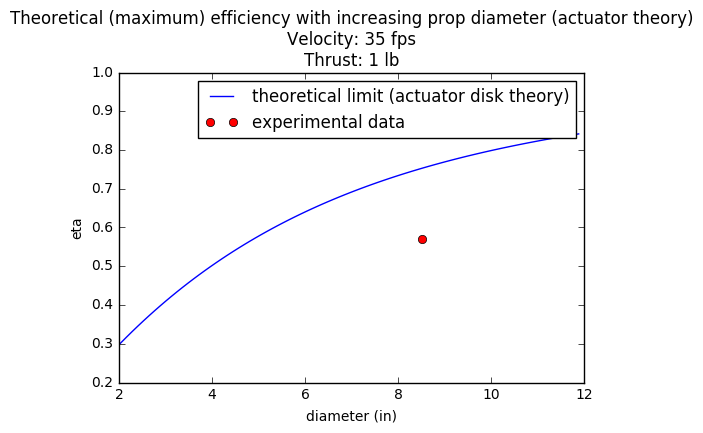

In [9]:
import matplotlib.pyplot as plt
import numpy as np

d = np.arange(0.1,1,0.01)
rho = 0.00237
u0 = 35
thrust = 1

eta = 2/(1 + (thrust/(pi*d**2/4*u0**2*rho/2) +1)**(1/2))

etasPlot = plt.figure()

plt.plot(d*12, eta, label = "theoretical limit (actuator disk theory)")
# plt.plot([7,12],[0.69,0.69], '--g')
# plt.plot([7,7],[0.2,0.69], '--g')


plt.plot(climb.diameter*12, climb.eta, 'ro', label = "experimental data")
plt.legend()
plt.title("Theoretical (maximum) efficiency with increasing prop diameter (actuator theory)\nVelocity: " + str(u0) + " fps\nThrust: 1 lb")
plt.xlabel("diameter (in)")
plt.ylabel("eta")
plt.xlim([2, 12])
plt.ylim([0.2, 1])
plt.show(etasPlot)


In [12]:

def getPRvPA(minSpeed, maxSpeed, fileString):
    global flightSpeed
    
    # this will just happen once
    for filename in glob.glob(fileString):
        # get propellor specs
        data = pd.read_table(filename, sep="\s+")
        dimensions = (filename.split("_"))
        diameter = float(dimensions[1].split("x")[0])/12 # in feet
        propName = dimensions[0].split("\\")[1]

        # we need the maximum and minimum j values to bound our possible ranges
        buffer = data.tail(1)['J']
        maxJ = float(buffer.values)
        buffer = data.head(1)['J']
        minJ = float(buffer.values)           

        rpms = []
        powers = []
     
    #for fs in np.arange(minSpeed, maxSpeed, (maxSpeed-minSpeed)/10):
    for fs in np.arange(70, 71, 5):

        flightSpeed = fs
        print("beginning to find power required with speed " + str(fs))

        #
        # find rpm, rps
        #
        minRpm = flightSpeed/(diameter*maxJ)*60
        maxRpm = flightSpeed/(diameter*minJ)*60
        print("rpms are between " + str(minRpm) + " and " + str(maxRpm))
        #
        # quickly iterate to find rpm
        lowGuess = minRpm
        highGuess = maxRpm
        guessRPM = (lowGuess + highGuess)/2
        #print(checkForPowerNeeded(maxRpm, data))
        powerHad = efficiency*ampLimit*voltage
        shaftPower = checkForPowerNeeded(guessRPM, data)

        # just to make sure we don't have infinite loop
        c = 1

        # make sure we can spin at a range where this power exists
        if checkForPowerNeeded(floor(maxRpm), data) < powerHad:
            print("This propellor is not valid for our power - propellor cannot use all available power at given RPM range")
        #    continue

        elif checkForPowerNeeded(ceil(minRpm), data) > powerHad:
            print("This propellor is not valid for our power - not enough power to reach minimum RPMs")
            continue

        # looks like we are on the chart! Keep going till we find RPM

        while abs(shaftPower - powerHad) > 0.2:
            c +=1

            if shaftPower > powerHad:
                highGuess = guessRPM

            else:
                lowGuess = guessRPM

            guessRPM = (lowGuess + highGuess)/2
            #print("lowGuess" + str(lowGuess))
            #print("highguess" + str(highGuess))
            print(guessRPM)
            powerHad = efficiency*ampLimit*voltage
            shaftPower = checkForPowerNeeded(floor(guessRPM), data)
            print("shaft power " + str(shaftPower))
            print("power had " + str(powerHad))
            #print(shaftPower)
            if c > 20:
                #print("breaking out!")
                #print("shaftPower: " + str(shaftPower))
                #print("powerHad: " + str(powerHad))

                break
        theRPM = floor(guessRPM)
        #print(theRPM)
        rpms.append(theRPM)
        powers.append(checkForPowerNeeded(theRPM, data))

        powerOut = "{0:.2f}".format(checkPowerOut(theRPM, data, flightSpeed))
        # print(powerOut)
        eta = "{0:.2f}".format(checkEta(theRPM, data))

        rps = theRPM/60
        j = flightSpeed/(rps*(diameter))

getPRvPA(15,65, "./UIUC-propDB/good-data/*ance_8.5x7_2882*.txt")



beginning to find power required with speed 70
rpms are between 6784.22398708 and 13853.7658054
8551.60944166
shaft power 59.42933730559433
power had 94.5
9435.30216894
shaft power 103.14844976950255
power had 94.5
8993.4558053
shaft power 83.26317166917613
power had 94.5
9214.37898712
shaft power 89.55375355178454
power had 94.5
9324.84057803
shaft power 99.55057809433463
power had 94.5
9269.60978258
shaft power 91.16703199810087
power had 94.5
9297.22518031
shaft power 91.99572846268809
power had 94.5
9311.03287917
shaft power 92.41195325531068
power had 94.5
9317.9367286
shaft power 92.59071894020677
power had 94.5
9321.38865332
shaft power 92.71002405034571
power had 94.5
9323.11461567
shaft power 99.51855109894659
power had 94.5
9322.2516345
shaft power 92.7398663325364
power had 94.5
9322.68312509
shaft power 92.7398663325364
power had 94.5
9322.89887038
shaft power 92.7398663325364
power had 94.5
9323.00674303
shaft power 99.51855109894659
power had 94.5
9322.9528067
shaft power

In [13]:
checkForPowerNeeded(maxRpm, data)


323.36333965042206